# Differential privacy basic concepts

There is a common situation is sociology where a researcher wants to develop a study about certain property on a population. The point is that this property is very sensitive and must remain private because could be embarrassing or illegal. However the researcher is able to get insights about the population without compromising their privacy. There is a simple mechanism in which every person follows a randomization algorithm that provides "plausible deniability". Suppose the following algorithm described by [Dwork].

1.- Flip a coin.

2.- If tails, then respond truthfully.

3.- If heads, then flip a second coin and respond "Yes" if heads and "No" if tails.

Even if the user answers "Yes", he could argue that this was due to the randomization algorithm and that this is not the true answer.

Imagine now that the researcher wants to use the previous algorithm to estimate the average number of people that have broken a particular law. The interesting point here is that we are able to obtain a very good aproximation of the value preserving the privacy of every individual. Let's see a concrete example to get more familiar with the situation.

First of all we are going to generate a binary random vector with a concrete mean given by $p$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shfl

p = 0.2
data_size = 10000
array = np.random.binomial(1,p,size=data_size)
np.mean(array)

Using TensorFlow backend.


0.2022

Let's suppose that every number represents if the person has broken the law. Now we are going to generate federated data from this array. Every node is going to have a number, simulating information in their mobile device for example.

In [2]:
federated_array = shfl.core.federated_operation.federate_array("broken_law_data", array, data_size)

Now, we want that every node executes the previously defined algorithm and returns the result.

In [3]:
from shfl.core import DataAccessDefinition
from shfl.core import RandomizeBinaryProperty

# Define allowed access to data. 
data_access_definition = DataAccessDefinition(dp_mechanism=RandomizeBinaryProperty())
federated_array.configure_data_access(data_access_definition)

# Query data
result = federated_array.query()

Let's compare the mean from original vector and the returned vector.

In [4]:
print("Generated binary vector with mean: " + str(np.mean(array)))
print("Differencial query mean result: " + str(np.mean(result)))

Generated binary vector with mean: 0.2022
Differencial query mean result: 0.347


What happened? Obviously, applying the randomization algorithm we have modified the true mean of the vector. We need to remove the influence of this to get the correct result. Fortunately, we can reverse the process to get a good estimation.

We are introducing noise half of the time with mean 0.5. So the expected value will be:

mean = real mean * 0.5 + random mean * 0.5

In [5]:
np.mean(array) * 0.5 + 0.5*0.5

0.35109999999999997

Pretty close. Isn't it? To get the real mean value we only need to use the following expression:

real mean = (mean - random mean * 0.5)/0.5

In [6]:
(np.mean(result) - 0.5*0.5)/0.5

0.19399999999999995

Right! We have obtained a number very similar to the truth. However, of course, introducing randomness is not free and we have introduced an error. In the next sections we are going to formalize this and study the effect of the population size, and the privacy in the algorithm.

## Differential Privacy definition
We introduce the notion of differential privacy [Dwork].

Let $\mathcal X$ be the set of possible rows in a database so that we can represent a particular database by a histogram $x\in\mathbb N^{|\mathcal X|}$. A randomized algorithm is a collection of conditional probabilities $P(z| x)$ for all $x$ and $z\in \mathcal Z$, where $\mathcal Z$ is the response space.

Differential privacy is a property of some randomized algorithms. in particular, a randomized algorithm is $\epsilon$-differentially private if, for all $z\in \mathcal Z$,

$$
\frac{P(z|x)}{P(z|y)}\le e^\epsilon
$$
 
for all databases $x, y \in\mathbb N^{|\mathcal X|}$ such that $||x-y||_1=1$. In words, this definition means that for any pair of similar databases, the probability of getting the same result after randomization is similar.

## Digging into the Randomized Response
Let's get back to sociological studies.

Suppose a group of $N$ people take part in a study that wants to estimate the proportion of the population that commits fraud when paying their taxes. Since this is a crime, the participants might be worried about the consequences of telling the truth, so they are told to follow the algorithm described previously.

This procedure is, in fact, an $\epsilon$-differentially private randomized mechanishm. In particular, we have that

$$
P(\text{respond yes} | \text{actual yes}) = \frac{3}{4}\qquad \qquad P(\text{respond no} | \text{actual yes}) = \frac{1}{4}\\
P(\text{respond yes} | \text{actual no}) = \frac{1}{4}\qquad \qquad P(\text{respond no} | \text{actual no}) = \frac{3}{4}\,,
$$

and a direct computation shows that $\epsilon = \log(3)$.

The probability of responding "Yes" is given by

$$
P(\text{respond yes}) = \frac{1}{4} + \frac{p}{2}
$$

where $p = P(\text{actual yes})$ is the quantity that wants to be estimated. Using that $P(\text{respond yes})$ is estimated to be $r_P = \frac{\#{\text{(respond yes)}}}{N}$, we have an estimate for the proportion of the population that commits fraud, namely

$$
\hat p = 2r_P - \frac{1}{2}\,.
$$

### Trade-off between accuracy and privacy

Now, we are going to create a set of useful functions to execute some experiments and try to understand better the behavior of the previous expressions. The framework provides an implementation of this algorithm using two parameters, the probabilities of getting "heads" in each of the two coins. For simplicity, we are going to consider the case in which the first coin is biased but the second one remains fair.

More explicitly, we consider the conditional probabilities given by

$$
P(\text{respond yes} | \text{actual yes}) = f \\
P(\text{respond yes} | \text{actual no}) = 1-f \,.
$$

with $f\in [1/2,1]$. This corresponds to taking the first coin with $p({\rm heads}) = 2(1-f)$ and the second coin to be unbiased. In this case we have that the amount of privacy depends on the bias of the first coin,

$$
\epsilon = \log \frac{f}{1-f}\,.
$$

For $f=1/2$, we have that $\epsilon = 0$ and the algorithm is maximally private. On the other hand, for $f = 1$, $\epsilon$ tends to infinity, so the algorithm is not private at all.

The relation between the number of positive responses and $p$ is given by

$$
\hat p = \frac{r_P + f - 1}{2f-1}\,.
$$

In order to properly see the trade-off between utility and privacy, we may look at the uncertainty of the estimate, which is given by

$$
\Delta p = \frac{2}{2f-1}\sqrt{\frac{r_P(1-r_P)}{N}}\,.
$$

This expression shows that, as the privacy increases ($f$ approaches $1/2$), the uncertainty of the estimate increases. On the other hand, for $f=1$, the uncertainty of the estimate is purely due to the finite size of the sample. In general, we see that the price we pay for being private is in accuracy of the estimate (for a fixed sample size). (The expression for the uncertainty is computed using the normal approximation to the error of a binomial distribution.)

In [7]:
def get_prob_from_epsilon(epsilon):
    f = np.exp(epsilon) / (1 + np.exp(epsilon))
    return 2*(1-f)

We also define the uncertainty function.

In [8]:
def uncertainty(dp_mean, n, epsilon):
    f = np.exp(epsilon) / (1 + np.exp(epsilon))
    estimation_uncertainty = 2/(2*f-1) * np.sqrt(dp_mean*(1-dp_mean) / n)
    return estimation_uncertainty

Finally, we define a function to execute the experiments $n_{runs}$ times so that we can study the average behavior.

In [9]:
def experiment(epsilon, p, size):
    array = np.random.binomial(1,p,size=size)
    federated_array = shfl.core.federated_operation.federate_array("fraudulent_data", array, size)
    
    prob = get_prob_from_epsilon(epsilon)
    # Define allowed access to data. 
    data_access_definition = DataAccessDefinition(dp_mechanism=RandomizeBinaryProperty(prob_head_first=prob))
    federated_array.configure_data_access(data_access_definition)
    # Query data
    result = federated_array.query()
    
    estimated_mean = (np.mean(result) - prob * 0.5)/(1-prob)
    estimation_uncertainty = uncertainty(np.mean(result), size, epsilon)
    return estimated_mean, estimation_uncertainty

def run_n_experiments(epsilon, p, size, n_runs):
    uncertainties = 0
    p_est = 0
    for i in range(n_runs):
        estimated_mean, uncertainty = experiment(epsilon,p,size)
        p_est = p_est + estimated_mean
        uncertainties = uncertainties + uncertainty
    p_est = p_est / n_runs
    uncertainties = uncertainties / n_runs    
    return p_est, uncertainties

Now, we are going to execute the experiment and save the results.

In [10]:
epsilon_range = np.arange(0.001, 10, 0.1)
n_range = [100, 500, 2000]
p_est = np.zeros((len(n_range), len(epsilon_range)))
uncertainties = np.zeros((len(n_range), len(epsilon_range)))
for i_n in range(len(n_range)):
    for i_e in range(len(epsilon_range)):
        p_est_i, uncertainty_i = run_n_experiments(epsilon_range[i_e], p, n_range[i_n], 10)
        p_est[i_n, i_e] = p_est_i
        uncertainties[i_n, i_e] = uncertainty_i

We can visualize the results.

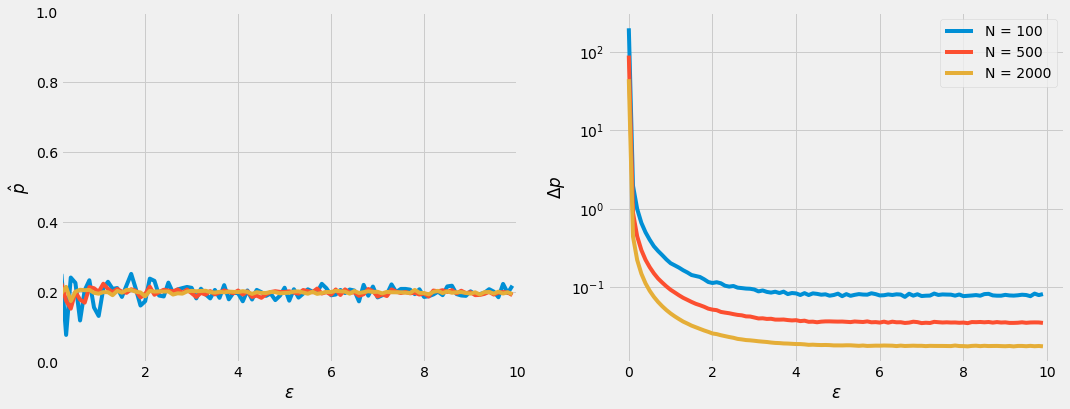

In [11]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
for i_n in range(len(n_range)):
    ax[0].plot(epsilon_range, p_est[i_n], label = "N = " + str(n_range[i_n]))   
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('$\hat p$')
ax[0].set_xlim([0.2, 10])
ax[0].set_ylim([0, 1])
        
for i_n in range(len(n_range)):
    ax[1].plot(epsilon_range, uncertainties[i_n], label = "N = " + str(n_range[i_n]))
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('$\Delta p$')
ax[1].set_yscale('log')
plt.legend(title = "", loc="upper right")
plt.show()